# 卡尔曼滤波：原理与应用

本笔记本使用Julia语言介绍卡尔曼滤波的基本原理和应用。我们将通过文学式编程的方式，结合理论和代码实现来理解这一重要的状态估计算法。

## 1. 引入必要的库

首先，我们需要导入实现卡尔曼滤波所需的Julia包。

In [66]:
using LinearAlgebra
using Plots
using Random
using Distributions
using Statistics

# 尝试使用 PyPlot 后端 (需要先安装: ]add PyPlot)
pyplot()
# 或尝试使用 GR 后端的特殊配置
# ENV["GKSwstype"] = "nul"
# gr()

# 设置支持中文的字体
default_font = "Arial Unicode MS"  # 或其他支持中文的字体
# default_font = "STSong"
Plots.default(fontfamily=default_font)

# 设置随机数种子
Random.seed!(123);
println("所有必要的库已加载完成！")



所有必要的库已加载完成！


## 2. 卡尔曼滤波理论基础

卡尔曼滤波是一种递归估计算法，用于从含有统计噪声和其他不确定性的观测数据中估计动态系统的状态。它的核心思想是结合预测模型和观测数据，以最优的方式估计系统状态。

### 2.1 线性动态系统

卡尔曼滤波适用于线性动态系统，可以用以下状态空间方程描述：

**状态方程**：
$$x_k = F_k x_{k-1} + B_k u_k + w_k$$

**观测方程**：
$$z_k = H_k x_k + v_k$$

其中：
- $x_k$ 是k时刻的系统状态
- $F_k$ 是状态转移矩阵
- $B_k$ 是控制输入矩阵
- $u_k$ 是控制输入
- $w_k$ 是过程噪声，假设服从均值为0，协方差为$Q_k$的正态分布
- $z_k$ 是观测值
- $H_k$ 是观测矩阵
- $v_k$ 是观测噪声，假设服从均值为0，协方差为$R_k$的正态分布

### 2.2 卡尔曼滤波算法流程

卡尔曼滤波算法包括两个主要步骤：预测和更新。

**预测步骤**：
1. 状态预测：$\hat{x}_{k|k-1} = F_k \hat{x}_{k-1|k-1} + B_k u_k$
2. 协方差预测：$P_{k|k-1} = F_k P_{k-1|k-1} F_k^T + Q_k$

**更新步骤**：
1. 计算卡尔曼增益：$K_k = P_{k|k-1} H_k^T (H_k P_{k|k-1} H_k^T + R_k)^{-1}$
2. 状态更新：$\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k (z_k - H_k \hat{x}_{k|k-1})$
3. 协方差更新：$P_{k|k} = (I - K_k H_k) P_{k|k-1}$

下面，我们将用Julia实现这个算法。

In [67]:
"""卡尔曼滤波器实现"""
mutable struct KalmanFilter
    # 状态空间维度
    state_dim::Int
    # 观测空间维度
    obs_dim::Int
    # 状态向量估计
    x::Vector{Float64}
    # 状态协方差矩阵
    P::Matrix{Float64}
    # 状态转移矩阵
    F::Matrix{Float64}
    # 控制输入矩阵
    B::Matrix{Float64}
    # 观测矩阵
    H::Matrix{Float64}
    # 过程噪声协方差
    Q::Matrix{Float64}
    # 观测噪声协方差
    R::Matrix{Float64}
    
    function KalmanFilter(state_dim::Int, obs_dim::Int)
        # 初始化滤波器参数
        x = zeros(state_dim)
        P = Matrix{Float64}(I, state_dim, state_dim)
        F = Matrix{Float64}(I, state_dim, state_dim)
        B = zeros(state_dim, state_dim)  # 默认无控制输入
        H = zeros(obs_dim, state_dim)
        Q = Matrix{Float64}(I, state_dim, state_dim) * 0.01
        R = Matrix{Float64}(I, obs_dim, obs_dim) * 0.01
        
        new(state_dim, obs_dim, x, P, F, B, H, Q, R)
    end
end

# 预测步骤
function predict!(kf::KalmanFilter, u::Vector{Float64}=zeros(kf.state_dim))
    # 状态预测
    kf.x = kf.F * kf.x + kf.B * u
    # 协方差预测
    kf.P = kf.F * kf.P * kf.F' + kf.Q
    
    return kf.x, kf.P
end

# 更新步骤
function update!(kf::KalmanFilter, z::Vector{Float64})
    # 计算卡尔曼增益
    S = kf.H * kf.P * kf.H' + kf.R
    K = kf.P * kf.H' * inv(S)
    
    # 状态更新
    y = z - kf.H * kf.x  # 测量残差
    kf.x = kf.x + K * y
    
    # 协方差更新
    I_mat = Matrix{Float64}(I, kf.state_dim, kf.state_dim)
    kf.P = (I_mat - K * kf.H) * kf.P
    
    return kf.x, kf.P
end

println("卡尔曼滤波器类已定义完成！")

卡尔曼滤波器类已定义完成！


## 3. 一维示例：恒速运动模型

让我们从一个简单的一维模型开始，假设一个物体以恒定速度运动，我们通过带有噪声的位置观测来估计其位置和速度。

In [68]:
function constant_velocity_example()
    # 时间参数
    dt = 0.1  # 采样时间间隔
    T = 10.0  # 总时间
    steps = Int(T/dt)  # 总步数
    
    # 真实状态初始值：[位置, 速度]
    true_x = [0.0, 1.0]  # 初始位置为0，速度为1m/s
    
    # 状态转移矩阵
    F = [1.0 dt; 0.0 1.0]  # 恒速模型
    
    # 观测矩阵（只观测位置）
    H = [1.0 0.0]
    
    # 过程噪声和观测噪声
    q = 0.01  # 过程噪声标准差
    r = 0.1   # 观测噪声标准差
    
    # 初始化卡尔曼滤波器
    kf = KalmanFilter(2, 1)
    kf.F = F
    kf.H = H
    kf.Q = [dt^3/3 dt^2/2; dt^2/2 dt] * q^2  # 连续白噪声离散化
      # 使用矩阵语法创建 1x1 矩阵
    kf.R = [r^2;;]  # 注意双分号，表示创建矩阵
    # 初始状态估计
    kf.x = [0.0, 0.0]  # 假设初始位置和速度都为0
    kf.P = [1.0 0.0; 0.0 1.0]  # 初始不确定性较大
    
    # 用于记录数据
    true_states = zeros(steps+1, 2)
    measurements = zeros(steps+1, 1)
    estimated_states = zeros(steps+1, 2)
    estimation_error = zeros(steps+1, 2)
    P_diag = zeros(steps+1, 2)  # 状态协方差矩阵对角线元素
    
    # 记录初始状态
    true_states[1,:] = true_x
    measurements[1,1] = true_x[1] + randn() * r
    estimated_states[1,:] = kf.x
    estimation_error[1,:] = true_x - kf.x
    P_diag[1,:] = [kf.P[1,1], kf.P[2,2]]
    
    # 主循环
    for k in 1:steps
        # 生成真实状态
        true_x = F * true_x + [0.5*q*dt^2, q*dt] .* randn(2)
        true_states[k+1,:] = true_x
        
        # 生成带噪声的观测
        z = H * true_x + r * randn(1)
        measurements[k+1,:] = z
        
        # 卡尔曼滤波预测-更新
        predict!(kf)
        update!(kf, z)
        
        # 记录结果
        estimated_states[k+1,:] = kf.x
        estimation_error[k+1,:] = true_x - kf.x
        P_diag[k+1,:] = [kf.P[1,1], kf.P[2,2]]
    end
    
    return true_states, measurements, estimated_states, estimation_error, P_diag, dt
end

# 运行示例
true_states, measurements, estimated_states, estimation_error, P_diag, dt = constant_velocity_example();
println("恒速模型示例已运行完成！")

恒速模型示例已运行完成！


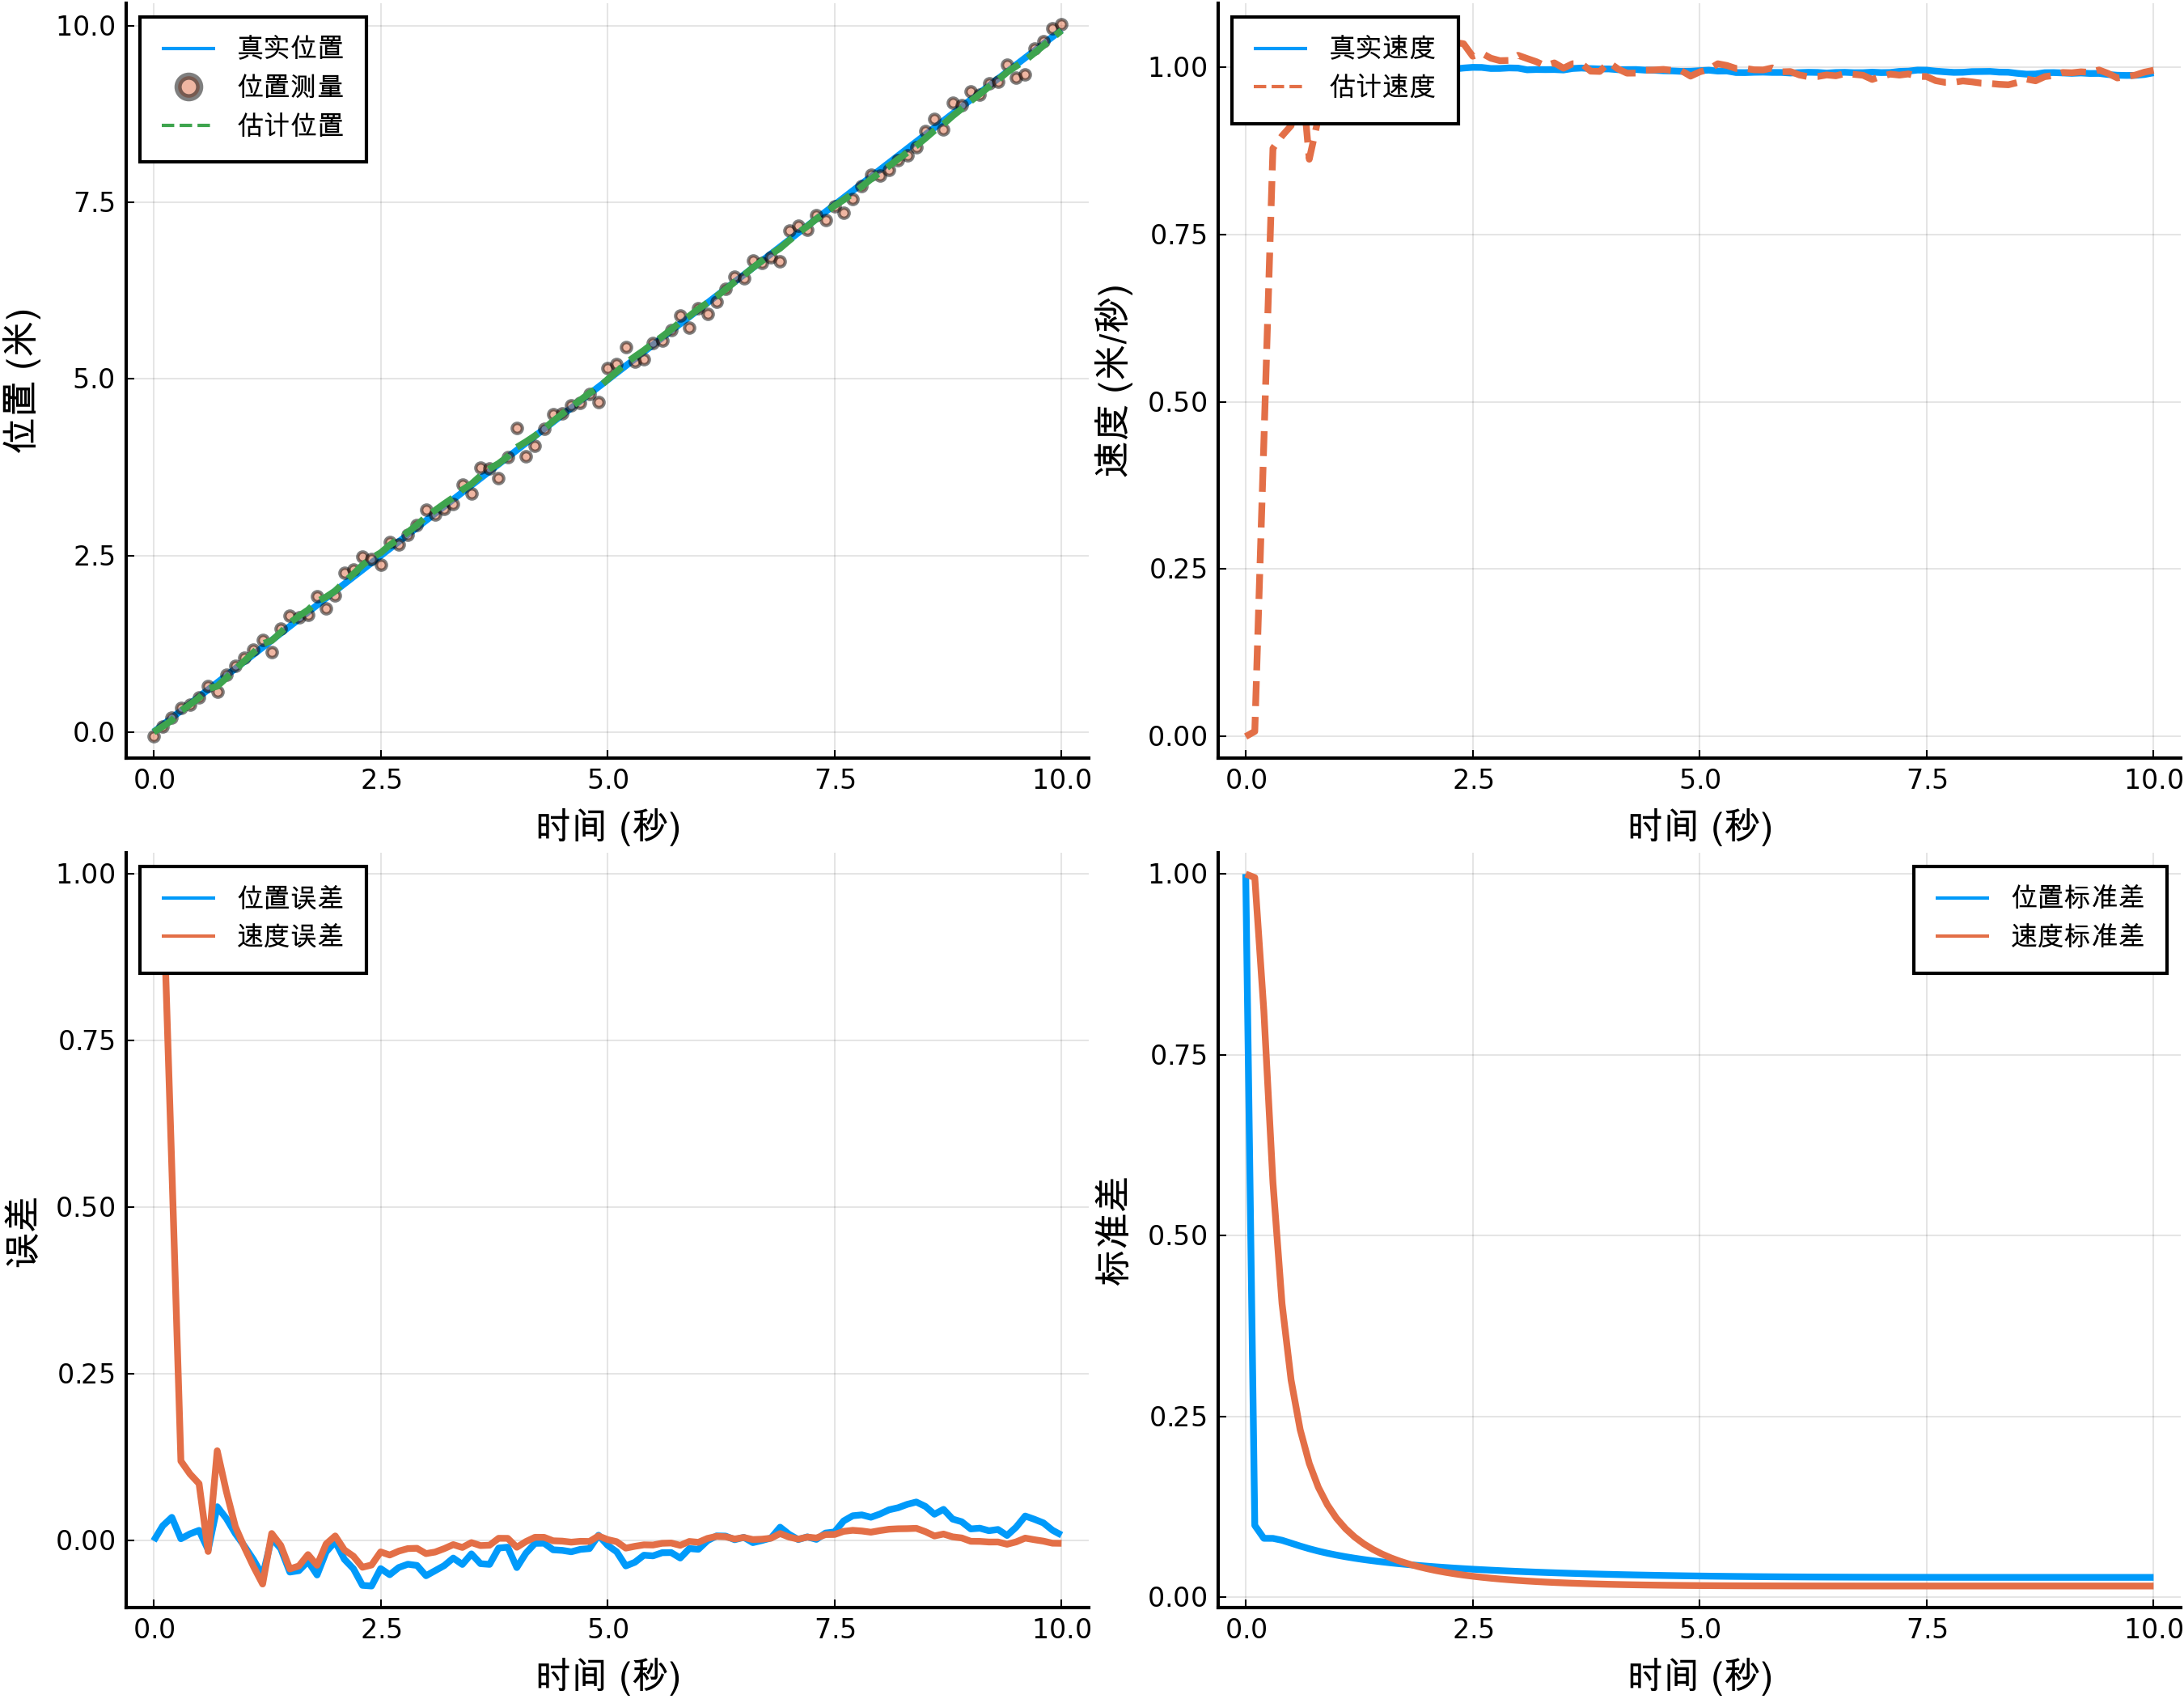

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [69]:
# 绘制结果
t = 0:dt:10

# 位置估计
p1 = plot(t, true_states[:,1], label="真实位置", linewidth=2, legend=:topleft, 
      xlabel="时间 (秒)", ylabel="位置 (米)")
scatter!(p1, t, measurements[:], label="位置测量", markersize=3, alpha=0.5)
plot!(p1, t, estimated_states[:,1], label="估计位置", linewidth=2, linestyle=:dash)

# 速度估计
p2 = plot(t, true_states[:,2], label="真实速度", linewidth=2, legend=:topleft,
      xlabel="时间 (秒)", ylabel="速度 (米/秒)")
plot!(p2, t, estimated_states[:,2], label="估计速度", linewidth=2, linestyle=:dash)

# 估计误差
p3 = plot(t, estimation_error[:,1], label="位置误差", linewidth=2,
      xlabel="时间 (秒)", ylabel="误差", legend=:topleft)
plot!(p3, t, estimation_error[:,2], label="速度误差", linewidth=2)

# 状态协方差
p4 = plot(t, sqrt.(P_diag[:,1]), label="位置标准差", linewidth=2, legend=:topright,
      xlabel="时间 (秒)", ylabel="标准差")
plot!(p4, t, sqrt.(P_diag[:,2]), label="速度标准差", linewidth=2)

# 合并图表
plot(p1, p2, p3, p4, layout=(2,2), size=(900,700), dpi=300)

## 4. 二维跟踪示例

现在我们来看一个更复杂的二维跟踪问题，物体在二维平面上运动，我们需要估计其位置和速度。

In [70]:
function tracking_2d_example()
    # 时间参数
    dt = 0.1  # 采样时间间隔
    T = 20.0  # 总时间
    steps = Int(T/dt)  # 总步数
    
    # 真实状态初始值：[x位置, x速度, y位置, y速度]
    true_x = [0.0, 1.0, 0.0, 1.0]  
    
    # 状态转移矩阵（二维恒速模型）
    F = [1.0 dt 0.0 0.0;
         0.0 1.0 0.0 0.0;
         0.0 0.0 1.0 dt;
         0.0 0.0 0.0 1.0]
    
    # 观测矩阵（只观测位置）
    H = [1.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0]
    
    # 过程噪声和观测噪声
    q = 0.01  # 过程噪声标准差
    r = 0.1   # 观测噪声标准差
    
    # 过程噪声协方差矩阵
    Q_sub = [dt^3/3 dt^2/2; dt^2/2 dt] * q^2
    Q = [Q_sub zeros(2,2); zeros(2,2) Q_sub]
    
    # 观测噪声协方差矩阵
    R = Matrix{Float64}(I, 2, 2) * r^2
    
    # 初始化卡尔曼滤波器
    kf = KalmanFilter(4, 2)
    kf.F = F
    kf.H = H
    kf.Q = Q
    kf.R = R
    
    # 初始状态估计
    kf.x = [0.0, 0.0, 0.0, 0.0]  # 假设初始位置和速度都为0
    kf.P = Matrix{Float64}(I, 4, 4)  # 初始不确定性较大
    
    # 用于记录数据
    true_positions = zeros(steps+1, 2)     # 真实位置 [x, y]
    measurements = zeros(steps+1, 2)       # 测量位置 [x, y]
    estimated_positions = zeros(steps+1, 2)  # 估计位置 [x, y]
    
    # 记录初始状态
    true_positions[1,:] = [true_x[1], true_x[3]]
    measurements[1,:] = true_positions[1,:] + r * randn(2)
    estimated_positions[1,:] = [kf.x[1], kf.x[3]]
    
    # 主循环
    for k in 1:steps
        # 真实轨迹：第10秒时改变运动方向
        if k*dt >= 10 && (k-1)*dt < 10
            true_x[2] = 0.5  # 减速
            true_x[4] = 1.5  # 增加垂直速度
        end
        
        # 更新真实状态
        true_x = F * true_x + sqrt.(Q) * randn(4)
        true_positions[k+1,:] = [true_x[1], true_x[3]]
        
        # 生成带噪声的观测
        z = H * true_x + sqrt.(R) * randn(2)
        measurements[k+1,:] = z
        
        # 卡尔曼滤波预测-更新
        predict!(kf)
        update!(kf, z)
        
        # 记录估计位置
        estimated_positions[k+1,:] = [kf.x[1], kf.x[3]]
    end
    
    return true_positions, measurements, estimated_positions, dt
end

# 运行二维跟踪示例
true_positions, measurements, estimated_positions, dt = tracking_2d_example();
println("二维跟踪示例已运行完成！")

二维跟踪示例已运行完成！


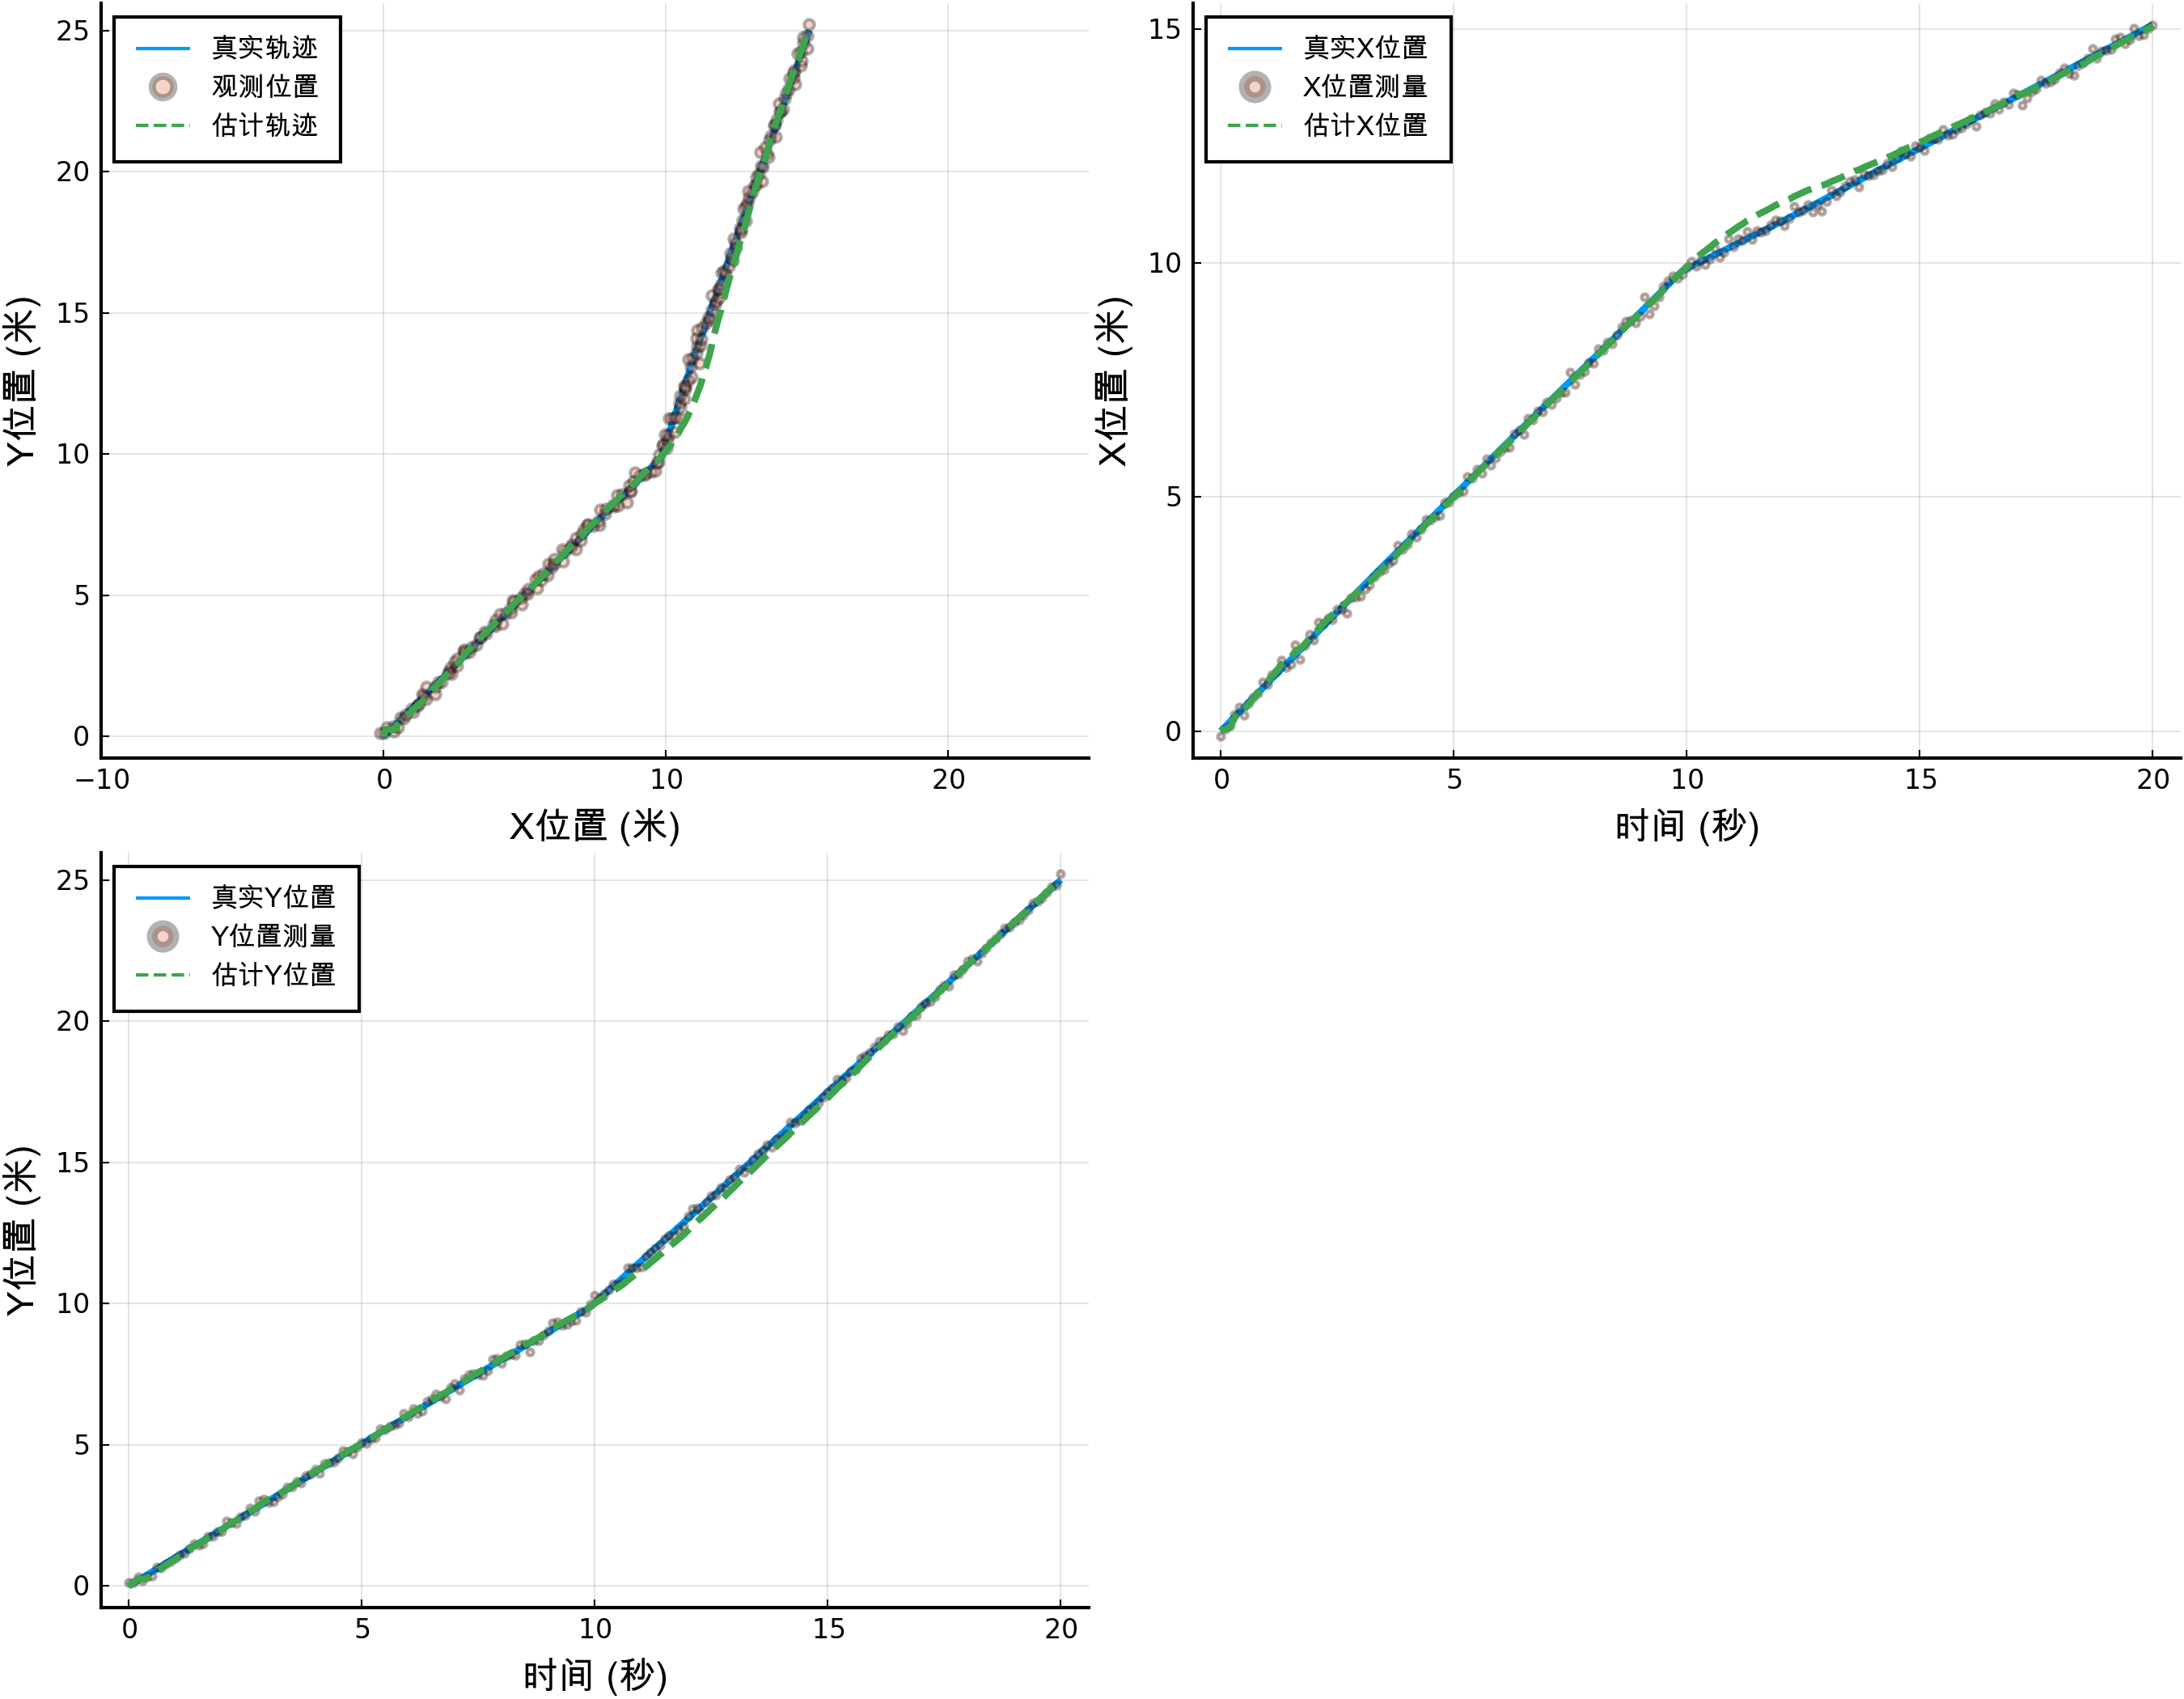

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [71]:
# 绘制二维跟踪结果
# 轨迹图
p1 = plot(true_positions[:,1], true_positions[:,2], 
           label="真实轨迹", linewidth=2, legend=:topleft,
           aspect_ratio=:equal, xlabel="X位置 (米)", ylabel="Y位置 (米)")
scatter!(p1, measurements[:,1], measurements[:,2], 
         label="观测位置", markersize=3, alpha=0.3)
plot!(p1, estimated_positions[:,1], estimated_positions[:,2], 
      label="估计轨迹", linewidth=2, linestyle=:dash)

# 随时间变化的X位置
t = 0:dt:20
p2 = plot(t, true_positions[:,1], label="真实X位置", linewidth=2, 
          legend=:topleft, xlabel="时间 (秒)", ylabel="X位置 (米)")
scatter!(p2, t, measurements[:,1], label="X位置测量", markersize=2, alpha=0.3)
plot!(p2, t, estimated_positions[:,1], label="估计X位置", linewidth=2, linestyle=:dash)

# 随时间变化的Y位置
p3 = plot(t, true_positions[:,2], label="真实Y位置", linewidth=2,
          legend=:topleft, xlabel="时间 (秒)", ylabel="Y位置 (米)")
scatter!(p3, t, measurements[:,2], label="Y位置测量", markersize=2, alpha=0.3)
plot!(p3, t, estimated_positions[:,2], label="估计Y位置", linewidth=2, linestyle=:dash)

# 合并图表
plot(p1, p2, p3, layout=(2,2), size=(900,700), dpi=300)

## 5. 扩展卡尔曼滤波

标准卡尔曼滤波适用于线性系统。对于非线性系统，我们可以使用扩展卡尔曼滤波（EKF），通过在当前估计点附近对非线性函数进行线性化来应对非线性问题。

扩展卡尔曼滤波的状态空间方程为：

**状态方程**：
$$x_k = f(x_{k-1}, u_k) + w_k$$

**观测方程**：
$$z_k = h(x_k) + v_k$$

其中：
- $f$ 是非线性状态转移函数
- $h$ 是非线性观测函数

在实现扩展卡尔曼滤波时，我们需要计算这些函数在当前估计状态附近的雅可比矩阵：

$$F_k = \frac{\partial f}{\partial x}\bigg|_{\hat{x}_{k-1|k-1}, u_k}$$

$$H_k = \frac{\partial h}{\partial x}\bigg|_{\hat{x}_{k|k-1}}$$

下面我们实现一个简单的扩展卡尔曼滤波器类。

In [72]:
"""扩展卡尔曼滤波器实现"""
mutable struct ExtendedKalmanFilter
    # 状态空间维度
    state_dim::Int
    # 观测空间维度
    obs_dim::Int
    # 状态向量估计
    x::Vector{Float64}
    # 状态协方差矩阵
    P::Matrix{Float64}
    # 过程噪声协方差
    Q::Matrix{Float64}
    # 观测噪声协方差
    R::Matrix{Float64}
    # 非线性状态转移函数
    f::Function
    # 非线性观测函数
    h::Function
    # 状态转移雅可比矩阵计算函数
    F_jacobian::Function
    # 观测雅可比矩阵计算函数
    H_jacobian::Function
    
    function ExtendedKalmanFilter(state_dim::Int, obs_dim::Int, 
                                 f::Function, h::Function,
                                 F_jacobian::Function, H_jacobian::Function)
        # 初始化滤波器参数
        x = zeros(state_dim)
        P = Matrix{Float64}(I, state_dim, state_dim)
        Q = Matrix{Float64}(I, state_dim, state_dim) * 0.01
        R = Matrix{Float64}(I, obs_dim, obs_dim) * 0.01
        
        new(state_dim, obs_dim, x, P, Q, R, f, h, F_jacobian, H_jacobian)
    end
end

# EKF预测步骤
function ekf_predict!(ekf::ExtendedKalmanFilter, u::Vector{Float64}=zeros(ekf.state_dim))
    # 使用非线性函数预测状态
    ekf.x = ekf.f(ekf.x, u)
    
    # 计算状态转移雅可比矩阵
    F = ekf.F_jacobian(ekf.x, u)
    
    # 预测状态协方差
    ekf.P = F * ekf.P * F' + ekf.Q
    
    return ekf.x, ekf.P
end

# EKF更新步骤
function ekf_update!(ekf::ExtendedKalmanFilter, z::Vector{Float64})
    # 计算观测雅可比矩阵
    H = ekf.H_jacobian(ekf.x)
    
    # 预测观测值
    z_pred = ekf.h(ekf.x)
    
    # 计算卡尔曼增益
    S = H * ekf.P * H' + ekf.R
    K = ekf.P * H' * inv(S)
    
    # 更新状态
    y = z - z_pred  # 测量残差
    ekf.x = ekf.x + K * y
    
    # 更新协方差
    I_mat = Matrix{Float64}(I, ekf.state_dim, ekf.state_dim)
    ekf.P = (I_mat - K * H) * ekf.P
    
    return ekf.x, ekf.P
end

println("扩展卡尔曼滤波器类已定义完成！")

扩展卡尔曼滤波器类已定义完成！


## 6. 非线性系统示例：目标跟踪

我们将使用扩展卡尔曼滤波器来解决一个雷达目标跟踪问题。在这个问题中，雷达测量目标的距离和方位角，但我们需要估计目标在直角坐标系中的位置和速度。

In [73]:
function radar_tracking_example()
    # 时间参数
    dt = 0.1  # 采样时间间隔
    T = 20.0  # 总时间
    steps = Int(T/dt)  # 总步数
    
    # 定义非线性状态转移函数（匀速直线运动模型）
    function f(x, u=zeros(4))
        F = [1.0 dt 0.0 0.0;
             0.0 1.0 0.0 0.0;
             0.0 0.0 1.0 dt;
             0.0 0.0 0.0 1.0]
        return F * x
    end
    
    # 定义雅可比矩阵
    function F_jacobian(x, u=zeros(4))
        return [1.0 dt 0.0 0.0;
                0.0 1.0 0.0 0.0;
                0.0 0.0 1.0 dt;
                0.0 0.0 0.0 1.0]
    end
    
    # 定义非线性观测函数：直角坐标到极坐标的转换
    # 输出 [r, theta]，其中 r 是距离，theta 是方位角
    function h(x)
        px, vx, py, vy = x
        r = sqrt(px^2 + py^2)  # 距离
        theta = atan(py, px)   # 方位角
        return [r, theta]
    end
    
    # 观测函数的雅可比矩阵
    function H_jacobian(x)
        px, vx, py, vy = x
        r = sqrt(px^2 + py^2)
        
        if r < 1e-10
            r = 1e-10  # 避免除零错误
        end
        
        # 极坐标对直角坐标的偏导数
        H = zeros(2, 4)
        H[1, 1] = px / r      # dr/dx
        H[1, 3] = py / r      # dr/dy
        H[2, 1] = -py / (px^2 + py^2)  # dtheta/dx
        H[2, 3] = px / (px^2 + py^2)   # dtheta/dy
        
        return H
    end
    
    # 初始化扩展卡尔曼滤波器
    ekf = ExtendedKalmanFilter(4, 2, f, h, F_jacobian, H_jacobian)
    
    # 设置噪声参数
    q = 0.01  # 过程噪声标准差
    r_range = 10.0    # 距离测量噪声标准差（米）
    r_angle = 0.01    # 角度测量噪声标准差（弧度）
    
    # 过程噪声协方差矩阵
    Q_sub = [dt^3/3 dt^2/2; dt^2/2 dt] * q^2
    ekf.Q = [Q_sub zeros(2,2); zeros(2,2) Q_sub]
    
    # 观测噪声协方差矩阵（对角矩阵，因为距离和角度测量误差相互独立）
    ekf.R = [r_range^2 0; 0 r_angle^2]
    
    # 真实状态初始值：[px, vx, py, vy]
    true_x = [1000.0, 20.0, 1000.0, -15.0]  
    
    # 初始状态估计（假设不太准确）
    ekf.x = [900.0, 25.0, 900.0, -10.0]
    ekf.P = Matrix{Float64}(I, 4, 4) * 100.0  # 较大的初始不确定性
    
    # 用于记录数据
    true_states = zeros(steps+1, 4)
    measurements = zeros(steps+1, 2)
    estimated_states = zeros(steps+1, 4)
    
    # 记录初始状态
    true_states[1,:] = true_x
    z_true = h(true_x)
    measurements[1,:] = z_true + [r_range * randn(), r_angle * randn()]
    estimated_states[1,:] = ekf.x
    
    # 主循环
    for k in 1:steps
        # 更新真实状态
        true_x = f(true_x) + sqrt.(ekf.Q) * randn(4)
        true_states[k+1,:] = true_x
        
        # 生成带噪声的极坐标观测
        z_true = h(true_x)
        z = z_true + [r_range * randn(), r_angle * randn()]
        measurements[k+1,:] = z
        
        # EKF预测-更新
        ekf_predict!(ekf)
        ekf_update!(ekf, z)
        
        # 记录估计状态
        estimated_states[k+1,:] = ekf.x
    end
    
    return true_states, measurements, estimated_states, dt
end

# 运行雷达跟踪示例
true_states, measurements, estimated_states, dt = radar_tracking_example();
println("雷达跟踪示例已运行完成！")

雷达跟踪示例已运行完成！


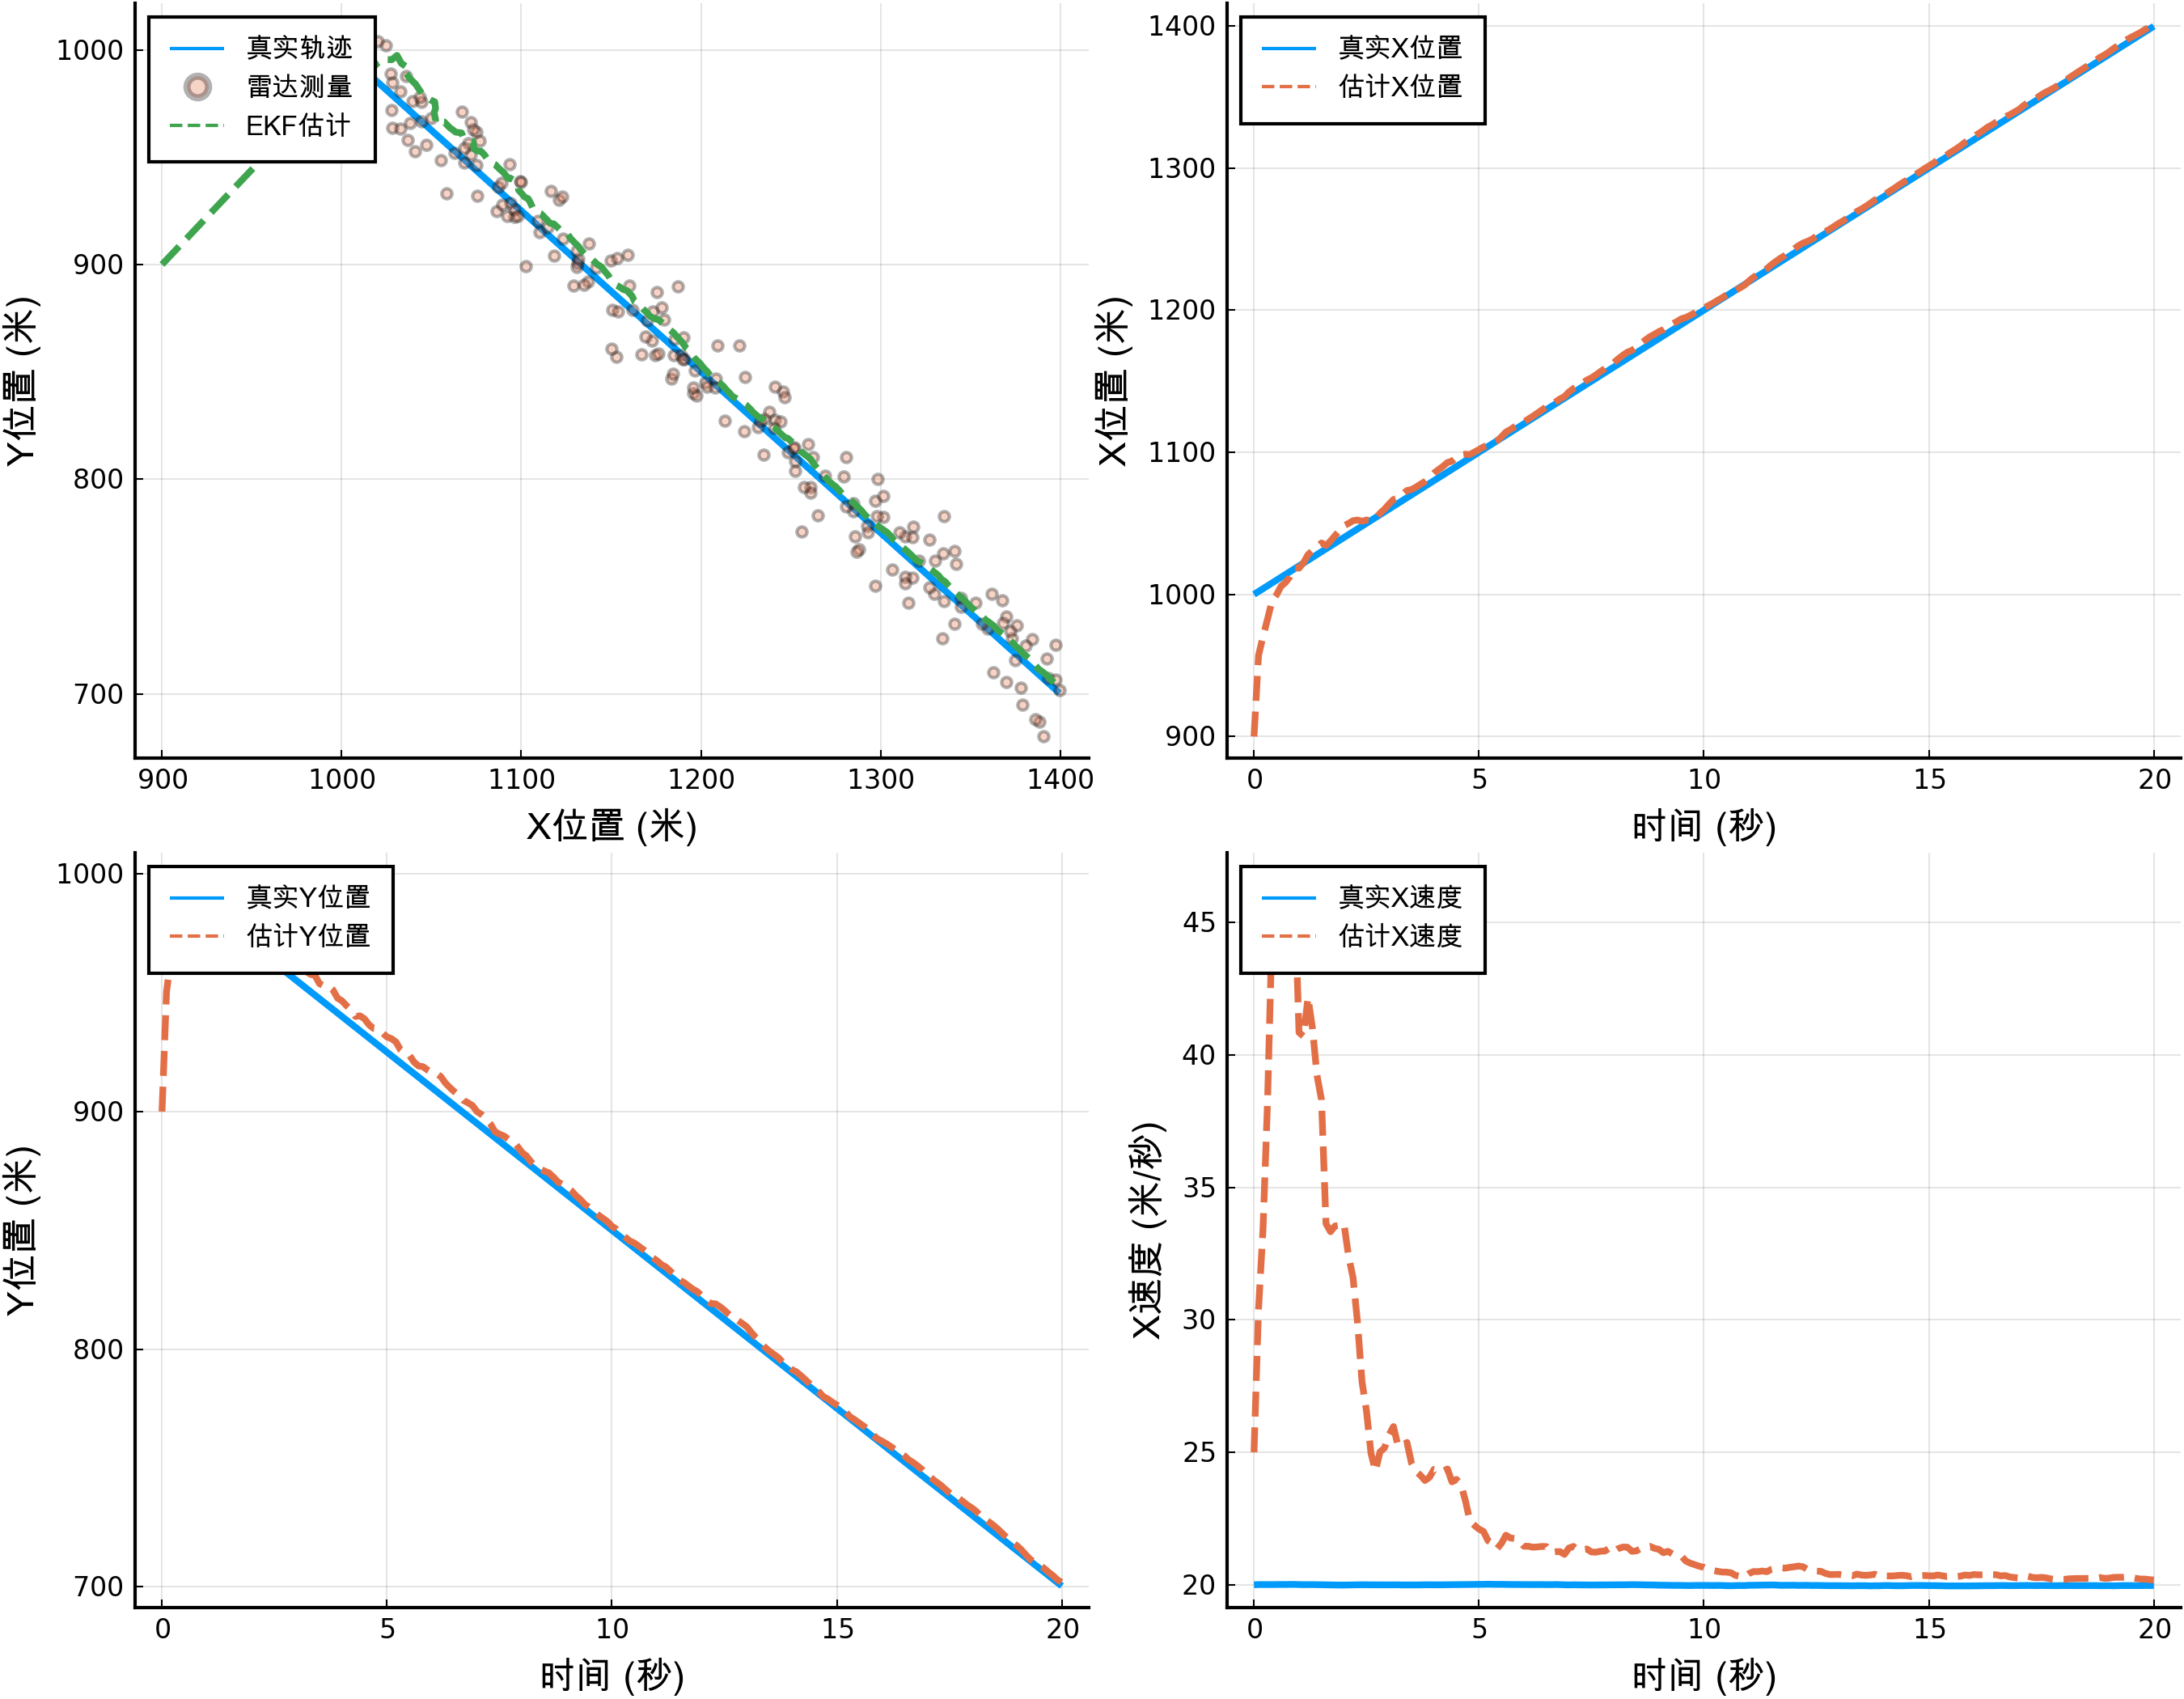

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [74]:
# 绘制雷达跟踪结果
t = 0:dt:20

# 计算从极坐标测量值转换回的直角坐标（用于可视化）
cartesian_measurements = zeros(length(measurements[:,1]), 2)
for i in 1:length(measurements[:,1])
    r = measurements[i,1]
    theta = measurements[i,2]
    cartesian_measurements[i,:] = [r*cos(theta), r*sin(theta)]
end

# 绘制轨迹
p1 = plot(true_states[:,1], true_states[:,3], 
           label="真实轨迹", linewidth=2, legend=:topleft,
           xlabel="X位置 (米)", ylabel="Y位置 (米)")
scatter!(p1, cartesian_measurements[:,1], cartesian_measurements[:,2], 
         label="雷达测量", markersize=3, alpha=0.3)
plot!(p1, estimated_states[:,1], estimated_states[:,3], 
      label="EKF估计", linewidth=2, linestyle=:dash)

# 随时间变化的X位置
p2 = plot(t, true_states[:,1], label="真实X位置", linewidth=2, 
          legend=:topleft, xlabel="时间 (秒)", ylabel="X位置 (米)")
plot!(p2, t, estimated_states[:,1], label="估计X位置", linewidth=2, linestyle=:dash)

# 随时间变化的Y位置
p3 = plot(t, true_states[:,3], label="真实Y位置", linewidth=2,
          legend=:topleft, xlabel="时间 (秒)", ylabel="Y位置 (米)")
plot!(p3, t, estimated_states[:,3], label="估计Y位置", linewidth=2, linestyle=:dash)

# X方向速度
p4 = plot(t, true_states[:,2], label="真实X速度", linewidth=2,
          legend=:topleft, xlabel="时间 (秒)", ylabel="X速度 (米/秒)")
plot!(p4, t, estimated_states[:,2], label="估计X速度", linewidth=2, linestyle=:dash)

# 合并图表
plot(p1, p2, p3, p4, layout=(2,2), size=(900,700), dpi=300)

## 7. 总结

在本笔记本中，我们系统地介绍了卡尔曼滤波及其扩展形式的原理和应用：

1. **基本原理**：卡尔曼滤波是一种递归估计算法，通过预测和更新两个步骤，融合预测模型和观测数据，以最优方式估计系统状态。

2. **线性卡尔曼滤波**：
   - 我们实现了标准卡尔曼滤波器的核心算法
   - 通过一维恒速运动模型展示了其工作原理
   - 扩展到二维跟踪问题，显示了它在多维状态估计中的应用

3. **扩展卡尔曼滤波**：
   - 针对非线性系统，我们实现了扩展卡尔曼滤波算法
   - 通过雷达目标跟踪问题，展示了处理非线性观测的能力

卡尔曼滤波的应用非常广泛，从导航系统、自动驾驶、信号处理到计算机视觉、金融市场分析等多个领域都有重要应用。理解其原理和实现方法对于处理含有噪声的实时数据估计问题具有重要意义。

通过Julia语言的简洁实现，我们不仅可以理解算法本身，还可以轻松地将其应用到实际问题中，并进行可视化分析。